# Multiclass Classification menggunakan Variational Quantum Classifier dan Optimizer COBYLA pada Dataset Iris

Pertama, setup environment.

Import library dan set random seed untuk reproducibility.

In [1]:
import numpy as np

# random seed
np.random.seed(30)

## Load data & preprocessing

Memuat dataset Iris yang berisi 150 sampel dengan 4 fitur (sepal length, sepal width, petal length, petal width) dan 3 kelas target (Setosa, Versicolor, Virginica).

In [2]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Normalisasi & Train-Test Split

Normalisasi data ke rentang [0, 1] menggunakan MinMaxScaler agar sesuai dengan quantum circuit. 

Data kemudian dibagi menjadi 70% training dan 30% testing.

In [3]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Split train-test (70:30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## Modeling Quantum Neural Network (QNN)

### Feature Map (Encoding Circuit)

ZFeatureMap adalah quantum circuit yang berfungsi untuk encoding data klasik menjadi quantum state. Proses ini sangat penting karena quantum computer hanya dapat memproses informasi dalam bentuk quantum state.

**Cara Kerja ZFeatureMap:**

- Menggunakan kombinasi gate **Hadamard (H)** dan **Controlled-Phase (CP)** untuk encoding
- Setiap fitur input $x_i$ di-encode menggunakan rotasi Z: $e^{-i x_i Z}$
- Parameter `reps=2` berarti encoding layer diulang 2 kali untuk meningkatkan ekspresivitas
- Dengan 4 qubit, kita dapat meng-encode 4 fitur dari dataset Iris

**Keuntungan:**

- Menciptakan quantum superposition yang memungkinkan eksplorasi banyak state sekaligus
- Entanglement antar qubit membantu menangkap korelasi non-linear antar fitur
- Kernel quantum yang dihasilkan dapat menangkap pattern yang sulit dipelajari oleh classical ML

/tmp/ipykernel_38265/3065338072.py:6: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)


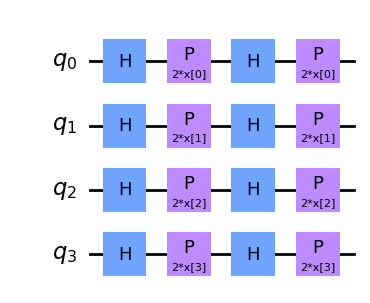

In [4]:
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA

num_qubits = 4
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)

# Visualisasi Feature Map (ZFeatureMap)
feature_map.decompose().draw(output='mpl', style='clifford')

### Ansatz (Variational Circuit)

RealAmplitudes adalah variational quantum circuit dengan parameter yang dapat dilatih (trainable parameters). Ansatz ini merupakan "model" quantum yang akan di-optimize selama training untuk mempelajari pattern data.

**Struktur RealAmplitudes:**

- Layer rotasi **RY gates** pada setiap qubit dengan sudut rotasi $\theta_i$ (parameter trainable)
- Diikuti entangling layer menggunakan **CNOT gates**
- Parameter `reps=3` berarti struktur layer ini diulang 3 kali
- `entanglement='full'` menciptakan koneksi maksimal antar qubit untuk pembelajaran kompleks

**Proses Pembelajaran:**

1. Parameter $\theta$ di-inisialisasi secara random
2. Optimizer (COBYLA) mengupdate nilai $\theta$ untuk meminimalkan loss function
3. Iterasi terus berlanjut hingga konvergen atau mencapai max iteration

**Fungsi Ansatz:**

- Bertindak sebagai **feature transformation** non-linear di quantum space
- Parameter yang ter-optimize mencerminkan **decision boundary** yang dipelajari
- Kombinasi dengan feature map membentuk **quantum kernel** yang powerful untuk klasifikasi

/tmp/ipykernel_38265/442996962.py:2: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3, entanglement='full')


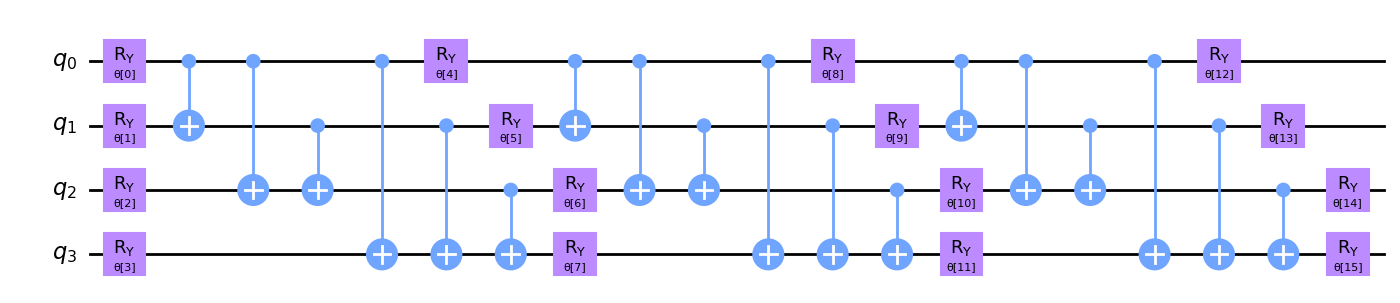

In [5]:
# Visualisasi Ansatz (RealAmplitudes)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3, entanglement='full')
optimizer = COBYLA(maxiter=150)
ansatz.decompose().draw(output='mpl', style='clifford')

## Training Model

### Training dengan One-vs-Rest (OvR) Strategy

**One-vs-Rest (OvR)** adalah strategi untuk mengubah multiclass classification menjadi beberapa binary classification problem.

- Jika tidak ada yang "mengklaim", digunakan fallback ke kelas 0

**Cara Kerja OvR:**- Voting system memilih kelas dengan score tertinggi

1. **Kelas 0 (Setosa)**: Model dilatih untuk membedakan "Setosa" vs "Bukan Setosa" (Versicolor + Virginica)- Saat prediksi, ketiga model memberikan confidence score

2. **Kelas 1 (Versicolor)**: Model dilatih untuk membedakan "Versicolor" vs "Bukan Versicolor" (Setosa + Virginica)**Prediksi:**

3. **Kelas 2 (Virginica)**: Model dilatih untuk membedakan "Virginica" vs "Bukan Virginica" (Setosa + Versicolor)

- Learning curve ditampilkan secara real-time untuk setiap kelas

**Proses Training:**- COBYLA optimizer melakukan maksimal 150 iterasi per model

- Total 3 VQC classifier independen dilatih- Label dikonversi: kelas target = 1, kelas lainnya = 0
- Setiap VQC menggunakan feature map dan ansatz yang sama

In [6]:
from qiskit_machine_learning.algorithms import VQC
import time

print("Mulai Training 3 Model Terpisah (Manual OvR)")

# Persiapan modeling
classifiers = {}
target_classes = [0, 1, 2]
class_names = ['Setosa', 'Versicolor', 'Virginica']
start_time = time.time()

# Training untuk setiap kelas
for cls in target_classes:
    print(f"\n{'='*60}")
    print(f"Training Detektor Kelas {cls} ({class_names[cls]})")
    print(f"{'='*60}")
    
    # Konversi ke binary classification (One-vs-Rest)
    y_train_binary = np.where(y_train == cls, 1, 0)
    positive = np.sum(y_train_binary == 1)
    negative = np.sum(y_train_binary == 0)
    print(f"Data: {positive} sampel '{class_names[cls]}' vs {negative} sampel 'Bukan {class_names[cls]}'")
    print("Training dimulai...\n")
    
    try:
        # Buat VQC classifier (simple & minimalis)
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            loss='squared_error'
        )
        
        # Training
        vqc.fit(X_train, y_train_binary)
        classifiers[cls] = vqc
        
        print(f"✓ Selesai training kelas {cls}")
        
    except Exception as e:
        print(f"✗ Error saat training kelas {cls}: {str(e)}")
        import traceback
        traceback.print_exc()

end_time = time.time()
elapsed = end_time - start_time
print(f"\n{'='*60}")
print(f"Waktu Total Training: {elapsed:.2f} detik ({elapsed/60:.2f} menit)")
print(f"{'='*60}")

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Mulai Training 3 Model Terpisah (Manual OvR)

Training Detektor Kelas 0 (Setosa)
Data: 31 sampel 'Setosa' vs 74 sampel 'Bukan Setosa'
Training dimulai...



No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


✓ Selesai training kelas 0

Training Detektor Kelas 1 (Versicolor)
Data: 37 sampel 'Versicolor' vs 68 sampel 'Bukan Versicolor'
Training dimulai...



No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


✓ Selesai training kelas 1

Training Detektor Kelas 2 (Virginica)
Data: 37 sampel 'Virginica' vs 68 sampel 'Bukan Virginica'
Training dimulai...

✓ Selesai training kelas 2

Waktu Total Training: 192.36 detik (3.21 menit)


## Evaluasi

### Prediksi & Classification Report

Menggunakan voting system untuk menggabungkan prediksi dari 3 classifier. Menampilkan contoh prediksi dan classification report lengkap dengan metrik precision, recall, dan F1-score untuk setiap kelas.

In [7]:
from sklearn.metrics import classification_report

# Fungsi untuk prediksi dengan voting
def predict_multiclass(classifiers, X):
    predictions = []
    for data_point in X:
        scores = []
        data_reshaped = data_point.reshape(1, -1)
        
        for cls in target_classes:
            pred = classifiers[cls].predict(data_reshaped)
            # Handle both array dan scalar - convert to int
            pred_value = int(np.asarray(pred).item())
            scores.append(pred_value)
        
        # Voting: pilih kelas dengan skor tertinggi
        if sum(scores) == 0:
            predictions.append(0)  # Fallback
        else:
            predictions.append(np.argmax(scores))
    
    return np.array(predictions)

# Prediksi untuk semua data
y_pred_train = predict_multiclass(classifiers, X_train)
y_pred_test = predict_multiclass(classifiers, X_test)

# Classification Report
print("TRAINING SET:")
print(classification_report(y_train, y_pred_train, target_names=['Setosa', 'Versicolor', 'Virginica']))

print("\nTEST SET:")
print(classification_report(y_test, y_pred_test, target_names=['Setosa', 'Versicolor', 'Virginica']))

TRAINING SET:
              precision    recall  f1-score   support

      Setosa       0.78      1.00      0.87        31
  Versicolor       0.87      0.73      0.79        37
   Virginica       0.94      0.86      0.90        37

    accuracy                           0.86       105
   macro avg       0.86      0.86      0.86       105
weighted avg       0.87      0.86      0.86       105


TEST SET:
              precision    recall  f1-score   support

      Setosa       0.76      1.00      0.86        19
  Versicolor       1.00      0.54      0.70        13
   Virginica       1.00      1.00      1.00        13

    accuracy                           0.87        45
   macro avg       0.92      0.85      0.85        45
weighted avg       0.90      0.87      0.86        45



### Confusion Matrix Visualization

Visualisasi confusion matrix untuk training dan test set. Matrix ini menunjukkan jumlah prediksi yang benar dan salah untuk setiap kelas, membantu mengidentifikasi pola kesalahan klasifikasi.

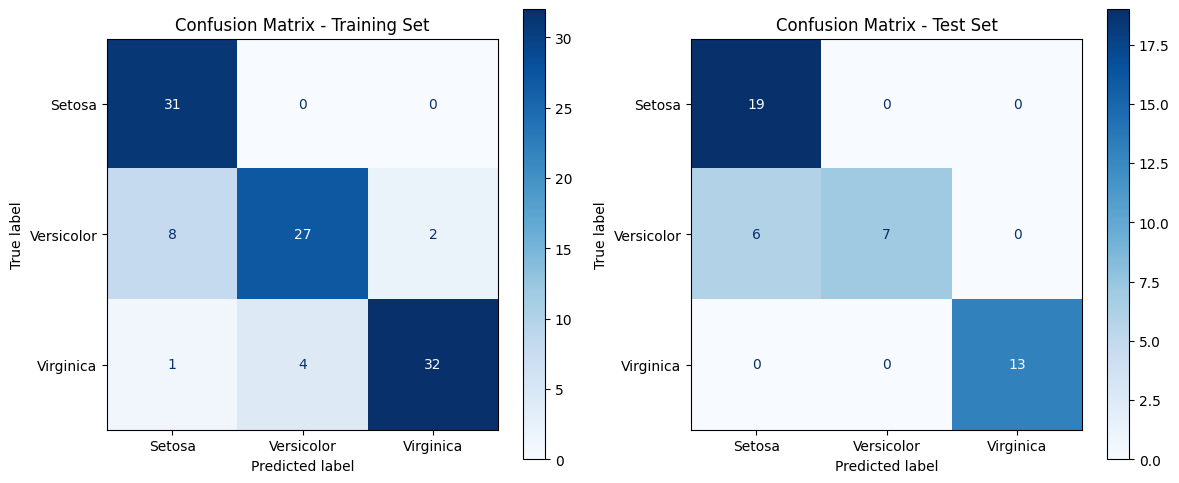

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training Confusion Matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Setosa', 'Versicolor', 'Virginica'])
disp_train.plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix - Training Set')

# Test Confusion Matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Setosa', 'Versicolor', 'Virginica'])
disp_test.plot(ax=ax[1], cmap='Blues')
ax[1].set_title('Confusion Matrix - Test Set')

plt.tight_layout()
plt.show()